In [1]:
import json
import numpy as np
import pandas as pd
import gensim
import networkx as nx

#import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from num2words import num2words
from pprint import pprint
from gensim.models import CoherenceModel

#import sklearn vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import seaborn as sns

In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [2]:
parsed_sites = 'abs_dict.json'

print("Started Reading JSON file")
with open(parsed_sites, "r") as read_file:
    abstract_dict = json.load(read_file)
    print("Decoded JSON Data From File")

Started Reading JSON file
Decoded JSON Data From File


In [3]:
abstract_df = pd.DataFrame.from_dict(abstract_dict)
abstract_df.head()

,doi,titles,abstracts,authors,keywords,sources
0,10.3390,Community Faecal Management Strategies and Per...,Most people in rural areas in South Africa (SA...,"[Matthew Mamera, Johan J. van Tol, Makhosazana...",agriculture,mdpi
1,10.3390,Adoption of Sustainable Agriculture Practices ...,The aim of this study was to highlight the imp...,"[Rafay Waseem, Gershom Endelani Mwalupaso, Far...",agriculture,mdpi
2,10.3390,Atlanta Residents’ Knowledge Regarding Heavy M...,Urban agriculture and gardening provide many h...,"[Lauren Balotin, Samantha Distler, Antoinette ...",agriculture,mdpi
3,10.3390,Perceptions of the Challenges and Opportunitie...,Waste management has become pertinent in urban...,"[Nqubeko Neville Menyuka, Melusi Sibanda, Urmi...",agriculture,mdpi
4,10.3390,An Assessment of Seaweed Extracts: Innovation ...,Plant growth regulators (PGRs) are described i...,"[El Chami Daniel, Galli Fabio]",agriculture,mdpi


In [4]:
keywords = abstract_df.groupby('keywords').count()
keywords.head(60)

,doi,titles,abstracts,authors,sources
keywords,,,,,
CNN,279,279,279,279,279
agric,21,21,21,21,21
agricultural technology,80,80,80,80,80
agriculture,227,227,227,227,227
agriculture CNN,215,215,215,215,215
agriculture computer vision,193,193,193,193,193
agriculture deep learning,35,35,35,35,35
agriculture machine learning,230,230,230,230,230
agriculture object recognition,211,211,211,211,211


In [5]:
agri_labels = ["agronomy", "agriculture", "mildew", "wheat", "barley", "agric"]
ML_labels = ["CNN", "computer vision", "deep learning", "image segmentation", "machine learning", "neural networks", "object recognition", "supervised learning", "unsupervised learning"]

abstracts = abstract_dict['abstracts']
agri_abstracts = []
ML_abstracts = []
mix = []
for i in range (len(abstract_dict["abstracts"])):
    if abstract_dict["keywords"][i] in agri_labels:
        agri_abstracts.append(abstract_dict["abstracts"][i])
    elif abstract_dict["keywords"][i] in ML_labels:
        ML_abstracts.append(abstract_dict["abstracts"][i])
    else:
        mix.append(abstract_dict["abstracts"][i])
        



In [6]:



#corpus = developer['abstracts']

# Preprocessing

def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def lemming(data):
    lemmatizer = WordNetLemmatizer() 
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text



def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = lemming(data)
    return data


# Preprocessing
def preprocess_corpus(corpus):
    preprocess_abstract = []
    for abstract in corpus:
        preprocess_abstract.append(word_tokenize(str(preprocess(abstract))))
        #list of lists of strings (words)
    return preprocess_abstract



"""
# Build the bigram and trigram models
# Careful: it might be worth creating th bigrams etc before dtemming and lemming
bigram = gensim.models.Phrases(preprocess_abstract) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[preprocess_abstract], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
"""



def make_bigrams(preprocess_abstract):
    data_processed = []
    bigram = gensim.models.Phrases(preprocess_abstract)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    for abstract in preprocess_abstract:
        data_processed.append(bigram_mod[abstract])
    return data_processed






<>:9: DeprecationWarning: invalid escape sequence \]
<>:9: DeprecationWarning: invalid escape sequence \]
<>:9: DeprecationWarning: invalid escape sequence \]
<ipython-input-6-50b580fca04f>:9: DeprecationWarning: invalid escape sequence \]
  symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"


## TF-IDF part



In [38]:
preprocess_abstract = preprocess_corpus(mix)
bigrams = make_bigrams(preprocess_abstract)

for i in range (len(bigrams)):
    inter = ""
    for j in range (len(bigrams[i])):
        inter+=" " + bigrams[i][j]
    bigrams[i]=inter





#calling the TfidfVectorizer
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(bigrams)

# here we are calculating the tf idf score (fitting it specifically in each bstract)
# and then summing the tf-idf scores on all the texts

words = {}
for i in range (len(bigrams)):
    response = tfidf.transform([bigrams[i]])
    feature_names = tfidf.get_feature_names()

    for col in response.nonzero()[1]:
        if feature_names[col] not in words.keys():
            words[feature_names[col]] = response[0, col]
        else:
            words[feature_names[col]] += response[0, col]
            
            
            
# Retrieving the words with highest sum of tf idf scores (not very pertinent)
nbr_words=103
copy = words.copy()


copy.pop("use")
copy.pop("two")
copy.pop("one")
copy.pop("data")


max_words = []



for i in range (nbr_words):
    maximum = max(copy, key=copy.get)  
    print(maximum, copy[maximum])
    max_words.append(maximum)
    copy.pop(maximum)
    

model 59.83290442544448
agricultur 58.950626345088374
imag 54.56352936534585
method 45.48755200820845
base 44.207347900412564
detect 44.20093142747362
crop 42.91492376269184
system 41.465599186736476
farm 40.56997785381264
predict 38.39629466276421
technolog 36.50402588225423
algorithm 35.185048267427526
develop 34.06061870493095
perform 32.925184231322746
product 31.498240865154077
differ 30.98310462742824
approach 30.457818993316007
machin_learn 30.131976930819967
applic 30.094393923485374
field 29.755313855961955
propos 29.322882828828728
improv 29.036640121482243
plant 28.67485748880548
studi 28.455334657076992
classif 27.158781078985996
result 26.702244734598743
dataset 26.571408646809257
process 25.978385644444675
techniqu 25.340211448765363
network 25.053085602134548
fruit 25.03120279115594
farmer 24.68959069837156
research 23.982070399189556
manag 23.485529975646347
accuraci 23.459967258335734
estim 23.4011925337802
inform 23.131269904166242
provid 22.9597608720807
analysi 22.2

In [42]:
#Retrieving the words of the corpus with highest tf idf scores

vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(bigrams)
feature_names = vectorizer.get_feature_names()
#print(matrix)
#print(bigrams[0])

words = []
scores = []
for j in range (len(bigrams)):
    doc = j
    feature_index = matrix[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [matrix[doc, x] for x in feature_index])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        words.append(w)
        scores.append(s)
        
        
nbr_words = 200
best_words = []
for i in range (nbr_words):
    index = scores.index(max(scores))
    if words[index] not in best_words:
        best_words.append(words[index])
    del(words[index])
    del(scores[index])
    
print(best_words)

['intern_audienc', 'co', 'avail_item', 'graphic', 'roof', 'compost', 'meso_institut', 'wetland', 'dark_spot', 'mangrov_forest', 'sea_cucumb', 'hlb', 'lane_mark', 'lwd_model', 'sheep', 'plant_factori', 'compress', 'sow_date', 'fen_peat', 'honey_bee', 'textil', 'ldquo', 'vsla', 'cassava_rice', 'tobacco_plant', 'sft', 'bc', 'claw', 'ozon', 'plant_phenotyp', 'hard', 'piglet', 'ispartof', 'yellow_rust', 'ca', 'bodi', 'tree_ring', 'sup', 'landmark', 'brown_sugar', 'po', 'rpl', 'co_op', 'uv', 'nose_tongu', 'cluster', 'ttp', 'insect', 'tuta', 'we', 'salmonella', 'tomato', 'mango', 'distribut', 'bud', 'den_scene', 'irrig_area', 'feed', 'modi', 'ecl', 'lightn', 'front_garden', 'terrac', 'dl', 'cameroon', 'broiler', 'sweeten', 'vad', 'fruit_fli', 'avocado', 'kernel', 'unitedmodel', 'anti_crispr', 'swarm', 'grape_leaf', 'access', 'fresh_tea', 'crack', 'payout', 'physiolog_respons', 'banana', 'anim', 'sup_fourteen', 'panicl', 'oil', 'uf', 'locul', 'strawberri', 'hatch_egg', 'ryegrass', 'kelembak', 

In [43]:
def co_occurence(max_words, corpus):
    matrix_dict = {}
    matrix = np.zeros((len(max_words), len(max_words)))
    for i in range (len(max_words)-1):
        for j in range (i+1, len(max_words)):
            matrix_dict[max_words[i]+" "+max_words[j]] = 0
            for abstract in corpus:
                if (max_words[i] in abstract) and (max_words[j] in abstract):
                    matrix[i,j]+=1
                    matrix[j,i]+=1
                    matrix_dict[max_words[i]+" "+max_words[j]] +=1
                    
                    
    print(matrix)
    return matrix, matrix_dict

co_matrix, matrix_dict = co_occurence(best_words, bigrams)         

[[  0.   5.   0. ...   0.   0.   0.]
 [  5.   0.   0. ... 187.   3.   2.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0. 187.   0. ...   0.   0.   0.]
 [  0.   3.   0. ...   0.   0.   0.]
 [  0.   2.   0. ...   0.   0.   0.]]


In [44]:
copy = matrix_dict.copy()
nbr_bigrams=100

d = {}
for i in range (nbr_words):
    maximum = max(copy, key=copy.get)  
    print(maximum, copy[maximum])
    d[maximum] = copy[maximum]
    copy.pop(maximum)
print(d)

de se 1937
st se 1936
co se 1922
de st 1922
ec st 1922
ec se 1921
an se 1921
an st 1920
de an 1918
co st 1909
co ec 1907
de ec 1907
ec an 1903
co de 1901
co an 1892
et se 1856
de et 1850
et st 1839
et an 1826
co et 1819
et ec 1816
se la 1772
st la 1766
de la 1765
po de 1763
po st 1761
po se 1758
ec la 1757
an la 1757
po an 1751
po ec 1749
co po 1748
co la 1744
se ag 1700
st ag 1698
de ag 1697
et la 1695
an ag 1694
ec ag 1690
pa st 1689
pa se 1689
pa an 1685
po et 1682
de pa 1680
ec pa 1676
co ag 1674
co pa 1669
po la 1641
et ag 1624
et pa 1618
st to 1611
to se 1610
ai st 1606
de to 1604
ai se 1603
ec to 1599
an to 1599
de ai 1595
co to 1588
co ai 1586
ai an 1584
ai ec 1576
ca st 1565
ca se 1561
po pa 1561
po ag 1559
co ca 1553
ca de 1553
pa la 1553
ca an 1552
ag la 1552
ca ec 1546
et to 1533
et ai 1530
ex st 1508
ex se 1505
co ex 1504
ca et 1499
de ex 1497
pa ag 1497
ai la 1496
ec ex 1494
to la 1485
po to 1483
ex an 1483
po ai 1480
et ex 1445
ca la 1440
ca po 1439
to ag 1422
ai pa 1421

land an 336
land la 336
co vision 335
av system 335
irt fa 334
st vision 334
se vision 332
oa model 332
de vision 331
the stem 331
appl thi 331
fa row 331
arg chi 330
we field 329
ion technolog 328
et vision 328
land st 328
eu pu 328
ear technolog 328
gi arg 327
ec vision 327
ex light 327
co land 326
ex plant 325
ec land 324
pu arg 324
we dd 323
sup gi 322
we sca 322
land se 322
an vision 322
stem oa 322
hen de 321
de land 321
sca ear 321
hen st 320
hen se 320
appl eq 320
dd ear 318
ear featur 318
hen an 317
the system 317
eu av 317
ear light 317
gi eu 316
dat gene 315
vision ag 314
co hen 313
dat sm 313
system oa 312
hen et 311
hen ec 311
dd fa 311
the thi 310
fa gene 310
fa light 310
fa field 308
stem eq 308
vision la 307
oa thi 307
po hen 306
po land 306
hen la 306
sca fa 306
system eq 305
oa eq 305
se cnn 304
po vision 303
we light 303
et land 303
et cnn 303
eu model 303
model thi 303
de cnn 302
land pa 300
eq model 300
land ag 299
hen ag 298
st cnn 298
ion gene 297
co cnn 296
ion 

['de', 'se'] 1937
['st', 'se'] 1936
['co', 'se'] 1922
['de', 'st'] 1922
['ec', 'st'] 1922
['ec', 'se'] 1921
['an', 'se'] 1921
['an', 'st'] 1920
['de', 'an'] 1918
['co', 'st'] 1909
['co', 'ec'] 1907
['de', 'ec'] 1907
['ec', 'an'] 1903
['co', 'de'] 1901
['co', 'an'] 1892
['et', 'se'] 1856
['de', 'et'] 1850
['et', 'st'] 1839
['et', 'an'] 1826
['co', 'et'] 1819
['et', 'ec'] 1816
['se', 'la'] 1772
['st', 'la'] 1766
['de', 'la'] 1765
['po', 'de'] 1763
['po', 'st'] 1761
['po', 'se'] 1758
['ec', 'la'] 1757
['an', 'la'] 1757
['po', 'an'] 1751
['po', 'ec'] 1749
['co', 'po'] 1748
['co', 'la'] 1744
['se', 'ag'] 1700
['st', 'ag'] 1698
['de', 'ag'] 1697
['et', 'la'] 1695
['an', 'ag'] 1694
['ec', 'ag'] 1690
['pa', 'st'] 1689
['pa', 'se'] 1689
['pa', 'an'] 1685
['po', 'et'] 1682
['de', 'pa'] 1680
['ec', 'pa'] 1676
['co', 'ag'] 1674
['co', 'pa'] 1669
['po', 'la'] 1641
['et', 'ag'] 1624
['et', 'pa'] 1618
['st', 'to'] 1611
['to', 'se'] 1610
['ai', 'st'] 1606
['de', 'to'] 1604
['ai', 'se'] 1603
['ec', 'to

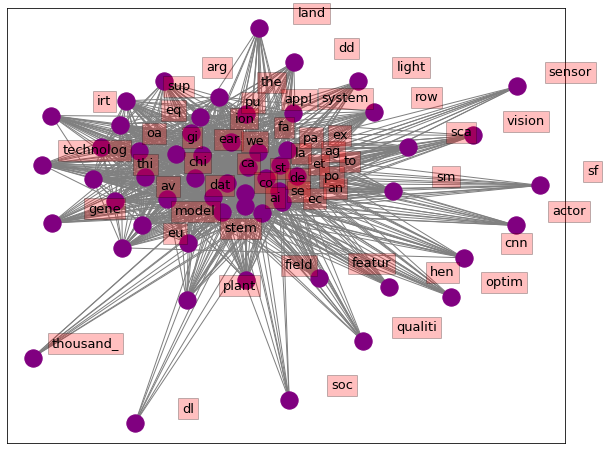

In [45]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d.items():

    k=k.split(" ")
    print(k, v)
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


In [ ]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

In [52]:
def build_LDA(corpus):
    preprocess_abstract = preprocess_corpus(corpus)
    bigrams = make_bigrams(preprocess_abstract)

    # Create Dictionary
    id2word = gensim.corpora.Dictionary(bigrams)

    # Create Corpus
    texts = bigrams

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    """
    # View
    print(corpus[:1])
    # Human readable format of corpus (term-frequency)
    print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])
    """


    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=20, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    """
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    """

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    return vis


build_LDA(agri_abstracts)

KeyboardInterrupt: 

In [13]:
build_LDA(ML_abstracts)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.367160  0.074915       1        1  31.214282
15     0.388125  0.102298       2        1  29.148388
2      0.329049  0.131342       3        1  16.500008
12     0.245219 -0.284690       4        1   7.118107
7      0.097314 -0.243057       5        1   3.257058
3      0.072737  0.070802       6        1   2.943188
6     -0.045548 -0.058962       7        1   2.469018
0     -0.045066  0.013632       8        1   1.640276
9     -0.075056  0.018596       9        1   1.152276
16    -0.089611 -0.016044      10        1   0.928064
8     -0.115106  0.012663      11        1   0.691384
14    -0.110028  0.005659      12        1   0.591040
1     -0.123340  0.020166      13        1   0.520630
5     -0.117300  0.016110      14        1   0.497287
11    -0.118693  0.019193      15        1   0.446683
10    -0.130887  0.022661      16        1   0.263113
17    -0.131445  0.023822      17        1   0.202897
4     -0.133352  0.023274      18        1   0.161751
18    -0.131416  0.023335      19        1   0.144111
19    -0.132756  0.024284      20        1   0.110440, topic_info=                   Term         Freq        Total Category  logprob  loglift
29                learn  1306.000000  1306.000000  Default  30.0000   30.000
87                model  2425.000000  2425.000000  Default  29.0000   29.000
206                  de   508.000000   508.000000  Default  28.0000   28.000
53                train  1424.000000  1424.000000  Default  27.0000   27.000
26                 imag  1462.000000  1462.000000  Default  26.0000   26.000
...                 ...          ...          ...      ...      ...      ...
9421            regener     0.013648     0.854889  Topic20  -9.3923    2.671
5821             partli     0.013648     0.854891  Topic20  -9.3923    2.671
8613          unpredict     0.013648     0.854892  Topic20  -9.3923    2.671
8662  candlestick_chart     0.013648     0.854898  Topic20  -9.3923    2.671
3633             extent     0.013648     0.854896  Topic20  -9.3923    2.671

[838 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1738      9  0.921743          ,_four
2242      1  0.357697              3d
2242      5  0.631678              3d
2978     15  0.852151      5g_network
490       1  0.996835             abl
...     ...       ...             ...
2774     10  0.923208  without_requir
1022      1  0.836678            work
1022      2  0.064551            work
1022      3  0.096826            work
2789     13  0.952635        workflow

[963 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 16, 3, 13, 8, 4, 7, 1, 10, 17, 9, 15, 2, 6, 12, 11, 18, 5, 19, 20])

In [15]:
build_LDA(mix)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.374108  0.042594       1        1  33.037645
14     0.375618 -0.105944       2        1  25.304315
6      0.336616 -0.097631       3        1  14.380423
19     0.159690  0.403147       4        1   8.966454
17     0.202583 -0.127830       5        1   6.220187
12     0.009147  0.041990       6        1   2.984238
3      0.071869 -0.007325       7        1   1.759440
13    -0.094909  0.020294       8        1   1.245325
7     -0.058451 -0.030068       9        1   1.037542
16    -0.063313 -0.004099      10        1   0.992169
5     -0.105735 -0.005166      11        1   0.655120
9     -0.140278 -0.015682      12        1   0.625420
2     -0.092331 -0.009080      13        1   0.562959
1     -0.137058 -0.015098      14        1   0.496998
4     -0.122101 -0.012422      15        1   0.424158
0     -0.141795 -0.013277      16        1   0.413616
15    -0.138229 -0.015625      17        1   0.394433
18    -0.144007 -0.016147      18        1   0.209024
11    -0.145417 -0.016287      19        1   0.170779
8     -0.146008 -0.016343      20        1   0.119757, topic_info=            Term         Freq        Total Category  logprob  loglift
992         farm  2939.000000  2939.000000  Default  30.0000  30.0000
183       detect  1569.000000  1569.000000  Default  29.0000  29.0000
203         imag  1516.000000  1516.000000  Default  28.0000  28.0000
0     agricultur  2614.000000  2614.000000  Default  27.0000  27.0000
33          data  2356.000000  2356.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2374        gain     0.015908     1.065735  Topic20  -9.8976   2.5229
2239       count     0.015908     1.065771  Topic20  -9.8976   2.5228
3036     prevent     0.015908     1.065716  Topic20  -9.8976   2.5229
3707      manner     0.015908     1.065719  Topic20  -9.8976   2.5229
3193      infrar     0.015908     1.065890  Topic20  -9.8976   2.5227

[843 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2178      4  0.993442         ,_nine
2036     11  0.995634        absorpt
1088      3  0.997199         access
268       1  0.629270       accuraci
268       2  0.018219       accuraci
...     ...       ...            ...
1344      9  0.943939             •a
1216     13  0.708820        •differ
970       9  0.923527  •machin_learn
1217     13  0.804537         •model
831       7  0.987491           •the

[929 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 15, 7, 20, 18, 13, 4, 14, 8, 17, 6, 10, 3, 2, 5, 1, 16, 19, 12, 9])

In [64]:


# To use the Mallet LDA you must download this:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip


def mallet_LDA(corpus, num_topics):
    preprocess_abstract = preprocess_corpus(corpus)
    bigrams = make_bigrams(preprocess_abstract)

    # Create Dictionary
    id2word = gensim.corpora.Dictionary(bigrams)

    # Create Corpus
    texts = bigrams

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    mallet_path = 'mallet-2.0.8/bin/mallet' 
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

    # Show Topics
    pprint(ldamallet.show_topics(formatted=False))

    # Compute Coherence Score
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=bigrams, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    print('\nCoherence Score: ', coherence_ldamallet)
    return ldamallet, coherence_ldamallet

In [17]:
mallet_LDA(mix, 20)

[(7,
  [('system', 0.018708381777824756),
   ('monitor', 0.015008984251136243),
   ('automat', 0.014586195962371842),
   ('measur', 0.013212134023887538),
   ('video', 0.013106436951696438),
   ('behavior', 0.012683648662932036),
   ('activ', 0.01056970721911003),
   ('record', 0.01056970721911003),
   ('time', 0.01035831307472783),
   ('highlight', 0.00993552478596343)]),
 (6,
  [('product', 0.06804830287206266),
   ('agricultur', 0.05099543080939948),
   ('develop', 0.03214751958224543),
   ('process', 0.01852154046997389),
   ('strategi', 0.01558420365535248),
   ('produc', 0.014115535248041775),
   ('studi', 0.014115535248041775),
   ('research', 0.014033942558746737),
   ('implement', 0.012973237597911228),
   ('increas', 0.01060704960835509)]),
 (16,
  [('method', 0.06391354689309148),
   ('imag', 0.0419915090698572),
   ('featur', 0.033114627556927824),
   ('algorithm', 0.021999228097259745),
   ('recognit', 0.01883442686221536),
   ('base', 0.01875723658818989),
   ('elsevi', 0

(<gensim.models.wrappers.ldamallet.LdaMallet at 0x7f144b1b2668>,
 0.5290494008184112)

In [18]:
def compute_coherence_values(corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model, coherencemodel = mallet_LDA(corpus, num_topics)
        model_list.append(model)
        coherence_values.append(coherencemodel)

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
start=8
limit=31
step=2
model_list, coherence_values = compute_coherence_values(corpus=mix, start=start, limit=limit, step=step)

[(0,
  [('system', 0.03510748146062142),
   ('crop', 0.020870490315717014),
   ('applic', 0.019775337150724364),
   ('plant', 0.018367283081448107),
   ('base', 0.016396007384461342),
   ('process', 0.01401796051190588),
   ('control', 0.012797646985199787),
   ('develop', 0.011420883006351887),
   ('requir', 0.010951531649926469),
   ('field', 0.01004411902750399)]),
 (1,
  [('farm', 0.01583050032622506),
   ('data', 0.00961505442807596),
   ('machin_learn', 0.009065622746471618),
   ('differ', 0.00882524638576972),
   ('cow', 0.008516191064867278),
   ('techniqu', 0.007279969781257512),
   ('level', 0.007176951340956698),
   ('pig', 0.00697091446035507),
   ('studi', 0.006833556539953985),
   ('approach', 0.006833556539953985)]),
 (2,
  [('imag', 0.024265333495915132),
   ('dataset', 0.018229484209242777),
   ('network', 0.01774173881233996),
   ('perform', 0.016857700280453605),
   ('propos', 0.015089623216680892),
   ('field', 0.013230093890988904),
   ('train', 0.01298622119253749


Coherence Score:  0.5053466640989205
[(4,
  [('model', 0.10510134365748121),
   ('predict', 0.029150535185606924),
   ('perform', 0.023969483033477568),
   ('machin_learn', 0.016795718515144616),
   ('approach', 0.014347529036665908),
   ('algorithm', 0.012184012753359143),
   ('power', 0.011273058528808928),
   ('base', 0.01115918925074015),
   ('method', 0.011045319972671374),
   ('gener', 0.010988385333636984)]),
 (6,
  [('predict', 0.02684008276677505),
   ('machin_learn', 0.01501625775938516),
   ('cow', 0.014661543009163464),
   ('model', 0.01418859000886787),
   ('method', 0.012710611882944133),
   ('studi', 0.011646467632279042),
   ('milk', 0.010464085131540053),
   ('anim', 0.010050251256281407),
   ('evalu', 0.00981377475613361),
   ('record', 0.009459060005911913)]),
 (10,
  [('de', 0.0340702210663199),
   ('develop', 0.02531426094495015),
   ('le', 0.020546163849154746),
   ('product', 0.017598612917208496),
   ('highlight', 0.014044213263979194),
   ('strategi', 0.013524


Coherence Score:  0.5457400107738438
[(19,
  [('estim', 0.02317421460628315),
   ('differ', 0.014443084455324358),
   ('yield', 0.014116687066503469),
   ('valu', 0.013055895552835577),
   ('result', 0.012403100775193798),
   ('plant', 0.012321501427988575),
   ('varieti', 0.01142390860873113),
   ('statu', 0.01109751121991024),
   ('select', 0.010526315789473684),
   ('appli', 0.009873521011831905)]),
 (5,
  [('de', 0.060377938239360884),
   ('le', 0.03318482101705331),
   ('highlight', 0.025503149485328006),
   ('la', 0.022123214011368873),
   ('en', 0.013673375326471041),
   ('•the', 0.013058841603933016),
   ('el', 0.011676140728222461),
   ('de_la', 0.008757105546166846),
   ('se', 0.008296205254263328),
   ('urban_farm', 0.006606237517283761)]),
 (6,
  [('time', 0.027036132401246527),
   ('measur', 0.025520087593699992),
   ('determin', 0.015918470479238608),
   ('develop', 0.014149751537100986),
   ('paramet', 0.012717931441084815),
   ('sampl', 0.011538785479659731),
   ('ten'


Coherence Score:  0.526251863628788
[(0,
  [('base', 0.02732539075308777),
   ('pig', 0.02218821729150727),
   ('system', 0.015958028199803256),
   ('monitor', 0.015958028199803256),
   ('automat', 0.014865012569679746),
   ('video', 0.01420920319160564),
   ('behavior', 0.013990600065580937),
   ('measur', 0.013553393813531534),
   ('process', 0.01311618756148213),
   ('detect', 0.011039457864247459)]),
 (13,
  [('detect', 0.08329070758738277),
   ('imag', 0.056947996589940326),
   ('method', 0.05541346973572037),
   ('base', 0.021909633418584824),
   ('accuraci', 0.021398124467178176),
   ('algorithm', 0.021057118499573743),
   ('propos', 0.019096334185848253),
   ('featur', 0.018499573742540496),
   ('segment', 0.015942028985507246),
   ('recognit', 0.015174765558397273)]),
 (11,
  [('model', 0.1219409282700422),
   ('predict', 0.07763713080168777),
   ('machin_learn', 0.04177215189873418),
   ('data', 0.03029535864978903),
   ('algorithm', 0.022953586497890296),
   ('perform', 0.0


Coherence Score:  0.5272191025340842


[0.5324737350040724, 0.49874179743875874, 0.5053466640989205, 0.514481551683011, 0.5200433095690078, 0.5457400107738438, 0.5294032670517368, 0.5206582593001786, 0.526251863628788, 0.5145115063767669, 0.5107671400640362, 0.5272191025340842]


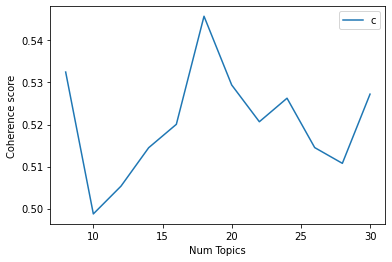

In [22]:
# Show graph
print(coherence_values)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
print(coherence_values)

[0.43157396307582285, 0.46263787110455074, 0.44300858554782263, 0.4471199758451803, 0.42981042058242697, 0.4447975748186329, 0.4373850803489953, 0.4483284603157475, 0.43000401484674317, 0.4284624813494124, 0.4342444364948314, 0.4366804641021528]


In [65]:
optimal_model, coherence = mallet_LDA(corpus=mix, num_topics=18)
print(optimal_model)

[(4,
  [('agricultur', 0.03001758352172821),
   ('farm', 0.02913840743531776),
   ('farmer', 0.025056518462697814),
   ('technolog', 0.017646320020095453),
   ('adopt', 0.015008791760864105),
   ('urban', 0.014318010550113038),
   ('product', 0.012559658377292138),
   ('impact', 0.011366490831449385),
   ('improv', 0.009356945491082642),
   ('food', 0.00916855061542326)]),
 (12,
  [('crop', 0.05464666349874415),
   ('field', 0.02701785350621139),
   ('data', 0.026882085398139976),
   ('map', 0.024506143506890232),
   ('area', 0.015952752698391148),
   ('yield', 0.015070259995926956),
   ('remot_sen', 0.012694318104677211),
   ('inform', 0.012151245672391555),
   ('base', 0.010725680537641709),
   ('land', 0.00930011540289186)]),
 (14,
  [('hundr_and', 0.025518008621888473),
   ('one_hundr', 0.022736754276178557),
   ('two_thousand', 0.02197190933110833),
   ('thousand_,', 0.02169378389653734),
   ('cow', 0.017243776943401474),
   ('one_thousand', 0.014879710749548046),
   ('twenti', 0.

In [66]:
corpus = mix
preprocess_abstract = preprocess_corpus(corpus)
bigrams = make_bigrams(preprocess_abstract)

# Create Dictionary
id2word = gensim.corpora.Dictionary(bigrams)

# Create Corpus
texts = bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=18, id2word=id2word)


def format_topics_sentences(ldamodel, corpus, texts = bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.0960,"crop, field, data, map, area, yield, remot_sen...","[introduct, field, base, phenotyp, promis, gat..."
1,1,5.0,0.4847,"plant, improv, perform, design, gener, researc...","[high, perform, comput, hpc, applic, essenti, ..."
2,2,0.0,0.1217,"product, agricultur, develop, technolog, proce...","[introduct, appl, one, import, fruit, world, c..."
3,3,12.0,0.1414,"crop, field, data, map, area, yield, remot_sen...","[introduct, potato, crop, solarium, tuberosum,..."
4,4,17.0,0.1046,"de, thousand_and, highlight, le, univers, la, ...","[introduct, two_thousand, and_seventeen, peach..."
5,5,0.0,0.1217,"product, agricultur, develop, technolog, proce...","[introduct, rapid, popul_growth, develop_count..."
6,6,15.0,0.1061,"system, base, estim, oper, sensor, uav, cluste...","[introduct, unman_aircraft, system, uass, disc..."
7,7,12.0,0.4106,"crop, field, data, map, area, yield, remot_sen...","[recent_year, unman_aerial, system_ua, emerg, ..."
8,8,7.0,0.5307,"water, irrig, increas, paramet, valu, manag, l...","[oil_palm, industri, vital, malaysian, economi..."
9,9,9.0,0.4498,"model, predict, machin_learn, variabl, algorit...","[compar, differ, analyt, method, explain, crop..."


In [67]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

    
Document_No = list(sent_topics_sorteddf_mallet.index)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

#keep Document_No
sent_topics_sorteddf_mallet["Document_No"] = Document_No

# Show
sent_topics_sorteddf_mallet.head(40)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Document_No
0,0.0,0.8543,"product, agricultur, develop, technolog, proce...","[actual, import, research, theme, combat, hung...",1347
1,1.0,0.7822,"practic, studi, function, soil, level, health,...","[одной, из, основных, тенденций, изменения, су...",1525
2,2.0,0.6620,"data, applic, agricultur, technolog, farm, man...","[machinelearn, ml, offer, newapproach, analyz,...",1628
3,3.0,0.8073,"dan, yang, dengan, one_hundr, °c, twenti, pada...","[pengembangan, pangan, fungsion, berbasi, baha...",1107
4,4.0,0.6326,"agricultur, farm, farmer, technolog, adopt, ur...","[agricultur_sector, nigeria, character, low, p...",1191
5,5.0,0.6141,"plant, improv, perform, design, gener, researc...","[keyword_comput, vision, semant_segment, synth...",1463
6,6.0,0.5789,"system, farm, pig, monitor, base, measur, anim...","[behavior, livestock_farm, primari, repres, an...",2005
7,7.0,0.5330,"water, irrig, increas, paramet, valu, manag, l...","[oil_palm, industri, vital, malaysian, economi...",119
8,8.0,0.6236,"detect, imag, method, algorithm, fruit, segmen...","[acquisit, qualiti, inform, plug_seedl, founda...",438
9,9.0,0.5090,"model, predict, machin_learn, variabl, algorit...","[wind_power, variabl, gener, resourc, therefor...",1746


In [72]:
for i in range (24):
    print("\n")
    print(sent_topics_sorteddf_mallet["Keywords"][i])
    print(mix[sent_topics_sorteddf_mallet["Document_No"][i]])



product, agricultur, develop, technolog, process, industri, energi, system, strategi, research
Actual importance of research theme: Combating hunger and providing the Earth’s population with sufficient amount of products is considered one of the strategic priorities of human civilization sustainable development by the UN up to 2030. The rapid growth of this planet’s human population in the 21st century, estimated at 7.6. billion people, leads to the global demand for production and foodstuff. Simultaneously, traditional strategies of extensive development conventional in the 20th century and “target” intensification of agriculture do not take expected positive effect nowadays. World economy requires for new strategies of agricultural production, as well as promoting ‘green revolution’ based on the ground of IT technology advances and “Industry 4.0.”. The generalization of world experience concerning development and implementing agricultural production strategies in the 21st century i

KeyError: 18